<a href="https://colab.research.google.com/github/auroramugnai/ArXivClassification/blob/main/ArXivClassification/clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clone the github repository and move to the inner directory.

In [2]:
!git clone https://github.com/auroramugnai/ArXivClassification.git
%cd ArXivClassification/ArXivClassification

Cloning into 'ArXivClassification'...
remote: Enumerating objects: 1625, done.
remote: Counting objects: 100% (264/264), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 1625 (delta 232), reused 197 (delta 196), pack-reused 1361
Receiving objects: 100% (1625/1625), 18.00 MiB | 19.65 MiB/s, done.
Resolving deltas: 100% (848/848), done.
/content/ArXivClassification/ArXivClassification


# 1) Build the dataset

In [3]:
import json
import os
import random
import zipfile

import dask.bag as db
import matplotlib.pyplot as plt
import pandas as pd

from utils import remove

ImportError: cannot import name 'remove' from 'utils' (/content/ArXivClassification/ArXivClassification/utils.py)

In [ ]:
SEED = 42 # fix random seed for reproducibility

## 1.1 Download the dataset
The following line of code comes from clicking on "Copy API command" in https://www.kaggle.com/datasets/Cornell-University/arxiv.

In [ ]:
!kaggle datasets download -d Cornell-University/arxiv

Dataset URL: https://www.kaggle.com/datasets/Cornell-University/arxiv
License(s): CC0-1.0
100% 1.28G/1.28G [00:21<00:00, 64.1MB/s]
100% 1.28G/1.28G [00:21<00:00, 64.0MB/s]


Unzip the downloaded file.

In [ ]:
with zipfile.ZipFile('./arxiv.zip', 'r') as zip_ref:
    zip_ref.extractall()

The unzipping creates an "arxiv-metadata-oai-snapshot.json". We now create a dask bag out of it.

In [ ]:
path = "./arxiv-metadata-oai-snapshot.json"
arxiv_data = db.read_text(path).map(json.loads)
arxiv_data.take(1)

({'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': None,
  'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with d

## 1.2 Get rid of some unnecessary information

In [ ]:
# Get the latest version of the articles.
get_latest_version = lambda x: x['versions'][-1]['created']

# Only keep articles published after 2022.
is_after_2022 = lambda x: int(get_latest_version(x).split(' ')[3]) > 2022

# Only keep articles that have at most 3 categories.
has_categs = lambda x: len(x['categories'].split(' ')) in {1,2,3}

# Only keep some information.
cut_info = lambda x: {'id': x['id'],
                      'title': x['title'],
                      'category':x['categories'].split(' '),
                      'abstract':x['abstract'],}

arxiv_data_filtered = (arxiv_data.filter(is_after_2022).filter(has_categs).map(cut_info).compute())

# Create a pandas dataframe and save it to csv.
df = pd.DataFrame(arxiv_data_filtered)
df.to_csv("./arxiv_data_filtered.csv", index=False)
df.head()

,id,title,category,abstract
0,0705.1329,Third Order Newton's Method for Zernike Polyno...,"[math.NA, cs.NA]",The Zernike radial polynomials are a system ...
1,0706.0190,Quantum Properties and Gravitational Field of ...,[physics.gen-ph],We find that a field with oscillations of ma...
2,0706.0859,"Profinite complexes of curves, their automorph...","[math.AG, math.NT]","Let ${\cal M}_{g,[n]}$, for $2g-2+n>0$, be t..."
3,0707.0434,Another generalization of Mason's ABC-theorem,[math.NT],We show a generalization of Mason's ABC-theo...
4,0707.0570,Gauss--Berezin integral operators and spinors ...,"[math.RT, math-ph, math.MP]",We obtain explicit formulas for the spinor r...


## 1.3 Get a fixed number of articles
To speed up computation and avoid a session crash.

In [ ]:
num_data = 20000 # number of articles that we want to keep
print(f"The dataset contains {len(df)} articles.")

# Sample the dataset only if its length exceeds num_data.
if(len(df) > num_data):
    n_sample = num_data
    random.seed(SEED)
    df = df.sample(n=n_sample, axis=0)

print(f"The dataset contains {len(df)} articles.")

The dataset contains 5000 articles.
The dataset contains 5000 articles.


# 2) Text processing

In [ ]:
!pip install -U spacy -q
!python -m spacy download en_core_web_md -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 8.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import en_core_web_md
import spacy
from tqdm import tqdm

In [ ]:
# Apply the remove function.
nlp = spacy.load("en_core_web_md")
tqdm.pandas() # to display progress bar

# First on abstracts.
clean_abs = lambda x: remove(text=x["abstract"], nlp=nlp)
df["clean_abstract"] = df.progress_apply(clean_abs, axis=1)

# Then on titles.
clean_tit = lambda x: remove(text=x["title"], nlp=nlp)
df["clean_title"] = df.progress_apply(clean_tit, axis=1)

df.tail()

100%|██████████| 5000/5000 [00:47<00:00, 104.51it/s]


,id,title,category,abstract,clean_abstract,clean_title,text
183429,2309.10357,Deep Mutual Learning across Task Towers for Ef...,[cs.IR],Recommender systems usually leverage multi-t...,recommender system usually leverage multi task...,deep mutual learning across task towers for ef...,deep mutual learning across task towers for ef...
9939,2108.01005,Sequoia: A Software Framework to Unify Continu...,[cs.LG],The field of Continual Learning (CL) seeks t...,the field of continual learning cl seek to dev...,sequoia a software framework to unify continua...,sequoia a software framework to unify continua...
121099,2305.15105,On the stability and deformability of top stars,"[gr-qc, hep-th]","Topological stars, or top stars for brevity,...",topological star or top star for brevity be sm...,on the stability and deformability of top star,on the stability and deformability of top star...
85263,2303.09934,Decidability of modal logics of non-$k$-colora...,"[math.LO, cs.LO]","We consider the bimodal language, where the ...",we consider the bimodal language where the fir...,decidability of modal logic of graph,decidability of modal logic of graph we consid...
2105,1905.09610,Hypothetical answers to continuous queries ove...,"[cs.PL, cs.AI]",Continuous queries over data streams may suf...,continuous query over data stream may suffer f...,hypothetical answer to continuous query over d...,hypothetical answer to continuous query over d...


In [ ]:
# Add a space to separate title and abstract.
df["clean_title"] = df["clean_title"].astype(str) + " "
df["text"] = df["clean_title"] + df["clean_abstract"]

# Save to csv.
df.to_csv(f"./processed_dataframe.csv", index=False)
df.head()

,id,title,category,abstract,clean_abstract,clean_title,text
22935,2205.14630,Physical Activation Functions (PAFs): An Appro...,[cs.LG],"In recent years, the gap between Deep Learni...",in recent year the gap between deep learning d...,physical activation functions paf an approach ...,physical activation functions paf an approach ...
86833,2303.11607,Transformers in Speech Processing: A Survey,"[cs.CL, cs.SD, eess.AS]",The remarkable success of transformers in th...,the remarkable success of transformer in the f...,transformer in speech processing a survey,transformer in speech processing a survey the ...
222206,2311.13695,BackboneLearn: A Library for Scaling Mixed-Int...,"[cs.LG, math.OC, stat.ML]",We present BackboneLearn: an open-source sof...,we present backbonelearn an open source softwa...,backbonelearn a library for scale mixed intege...,backbonelearn a library for scale mixed intege...
230209,2312.03458,Think from Words(TFW): Initiating Human-Like C...,[cs.CL],The proliferation of Large Language Models (...,the proliferation of large language models llm...,think from initiate human like cognition in la...,think from initiate human like cognition in la...
132745,2306.07572,Clairaut anti-invariant Riemannian maps to tra...,[math.DG],"In this article, we introduce Clairaut anti-...",in this article we introduce clairaut anti inv...,clairaut anti invariant riemannian map to tran...,clairaut anti invariant riemannian map to tran...


# 3) Vectorization

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Convert the texts into a TF-IDF matrix.
text = df["text"].values
vectorizer = TfidfVectorizer(max_features=2**12, stop_words='english')

X = vectorizer.fit_transform(text)

# 4) Dimensionality reduction with PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# Reduce the dimensionality of the data to 3.
n_components = 3
pca = PCA(n_components=n_components, random_state=42)
tqdm.pandas()
X_reduced = pca.fit_transform(X.toarray())
X_reduced.shape

(5000, 3)

# 5) Find the number of clusters with K-Means

In [ ]:
!pip install kneed -q

In [ ]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from kneed import KneeLocator

<Figure size 640x480 with 0 Axes>

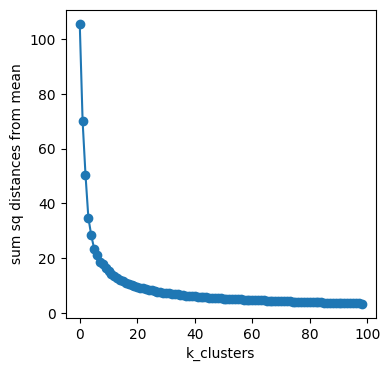

In [ ]:
# Perform the cluster algorithm k_max times and calculate the sum squared distances from mean.
cluster_errors = []

k_max = 100
for i in range(1, k_max):
    n_clusters = i
    pipe_pca_kmean = Pipeline([("cluster", KMeans(n_init='auto',
                                                  n_clusters=n_clusters,
                                                  random_state=SEED,
                                                  verbose=0)
                                )])

    pipe_pca_kmean.fit(X_reduced)
    pipe_pca_kmean.predict(X_reduced)
    cluster_errors.append(pipe_pca_kmean.named_steps["cluster"].inertia_)

# Plot the sum squared distances from mean.
plt.clf()
plt.figure(figsize=(4,4))
plt.plot(cluster_errors, "o-")
plt.xlabel("k_clusters")
plt.ylabel("sum sq distances from mean")
plt.show()

In [ ]:
# Find the optimal value of k with KneeLocator.
kl = KneeLocator(range(1, k_max), cluster_errors, curve="convex", direction="decreasing")

# 6) Predict the clusters on our dataset

In [ ]:
k_optimal = kl.elbow
print('k_optimal = ', k_optimal)

k_optimal =  12


In [ ]:
from sklearn.cluster import KMeans

In [ ]:
# Predict the clusters.
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init='auto')
y_pred = kmeans.fit_predict(X_reduced)

# 7) Plot the clusters with UMAP


In [ ]:
!pip install umap-learn -q

In [ ]:
import plotly.express as px
from umap import UMAP

In [ ]:
# UMAP definition.
umap_embeddings = UMAP(min_dist=0.1, n_components=n_components)
X_umap = umap_embeddings.fit_transform(X_reduced)


# Plot.
x, y, z = list(zip(*X_umap))
fig = px.scatter_3d(df, x, y, z, color=y_pred.astype(str),
                    color_discrete_sequence=px.colors.qualitative.Dark24,
                    hover_data=['category', 'title'])
fig.update_traces(marker_size=3)
fig.show()